# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [2]:
! git clone https://www.github.com/LexiVanMetre/assignment4

Cloning into 'assignment4'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 9
Receiving objects: 100% (11/11), 396.68 KiB | 3.64 MiB/s, done.


**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from scipy import stats

In [60]:
carData = pd.read_csv('./assignment4/data/cars_hw.csv')
carData.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [61]:
print(carData.dtypes)

Unnamed: 0            int64
Make                 object
Make_Year             int64
Color                object
Body_Type            object
Mileage_Run           int64
No_of_Owners         object
Seating_Capacity      int64
Fuel_Type            object
Transmission         object
Transmission_Type    object
Price                 int64
dtype: object


We need to convert make year to a Date or factor type.

<Axes: >

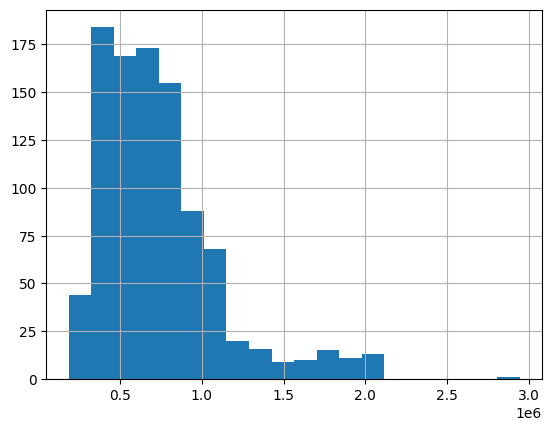

In [21]:
carData['Price'].hist(bins=20) # prices are slightly skewed to the right

In [62]:
carData['Make_Year'] = carData['Make_Year'].astype('category')

carData = carData.drop(carData.columns[0], axis = 1)

## removing characters in the No_of_Owners column:
carData['No_of_Owners'] = carData['No_of_Owners'].str.replace(r'\D', '', regex=True).astype(int)

In [63]:
carData.head()

,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,Volkswagen,2017,silver,sedan,44611,1,5,diesel,7-Speed,Automatic,657000
1,Hyundai,2016,red,crossover,20305,1,5,petrol,5-Speed,Manual,682000
2,Honda,2019,white,suv,29540,2,5,petrol,5-Speed,Manual,793000
3,Renault,2017,bronze,hatchback,35680,1,5,petrol,5-Speed,Manual,414000
4,Hyundai,2017,orange,hatchback,25126,1,5,petrol,5-Speed,Manual,515000


In [79]:
# checking the categorical variables to make sure that there are no misspellings in the group names that we need to fix:
print(X['Make'].value_counts())
print('----------------------------')

print(X['Color'].value_counts())
print('----------------------------')

print(X['Body_Type'].value_counts())
print('----------------------------')

print(X['Fuel_Type'].value_counts())
print('----------------------------')

print(X['Transmission'].value_counts())
print('----------------------------')

print(X['Transmission_Type'].value_counts())
print('----------------------------')

Hyundai          305
Maruti Suzuki    293
Honda             73
Renault           68
Ford              52
Toyota            50
Volkswagen        29
Tata              19
Mahindra          18
MG Motors         15
Kia                8
Chevrolet          6
Nissan             4
Jeep               4
Skoda              4
Datsun             3
Name: Make, dtype: int64
----------------------------
white     187
red       178
grey      163
silver    132
blue      128
brown      70
black      33
orange     19
bronze     12
beige       9
yellow      6
purple      6
golden      3
maroon      3
green       2
Name: Color, dtype: int64
----------------------------
hatchback    484
sedan        226
suv          182
muv           38
crossover     21
Name: Body_Type, dtype: int64
----------------------------
petrol        782
diesel        167
petrol+cng      2
Name: Fuel_Type, dtype: int64
----------------------------
5-Speed    739
6-Speed    155
4-Speed     39
7-Speed     15
CVT          3
Name: Transmi

In [96]:
carData = carData.drop(carData[carData['Fuel_Type'] == 'petrol+cng'].index)

In [97]:
def visualize_outliers(df, column_name):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column_name])
    plt.title(f'Box plot of {column_name}')
    plt.show()

def handle_outliers(df, column_name, threshold=3):
    z_scores = stats.zscore(df[column_name])
    outliers = (abs(z_scores) > threshold)
    df_cleaned = df[~outliers]
    return df_cleaned

def scale_variable(df, column_name):
    df[column_name] = np.log1p(df[column_name])
    return df

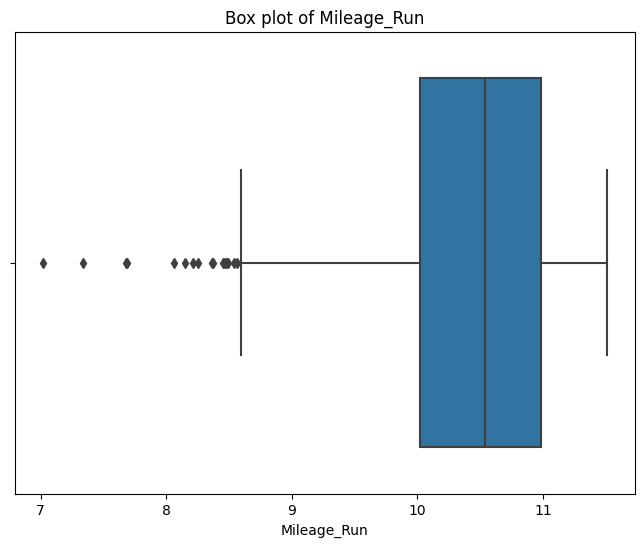

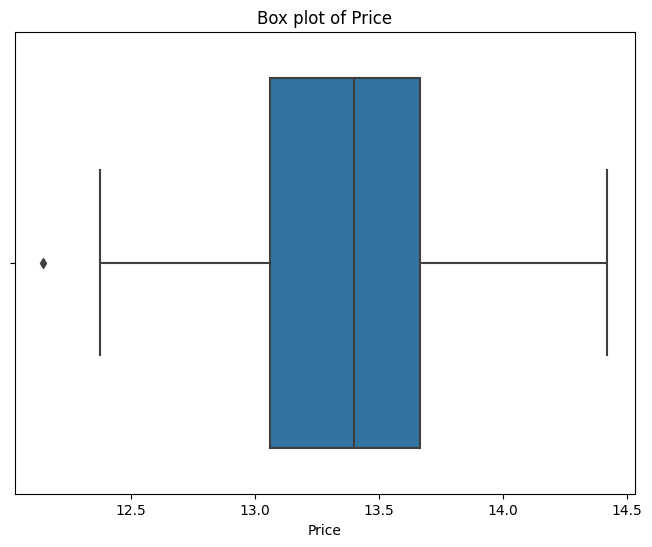

In [98]:
# Visualizing outliers
columns_to_visualize = ['Mileage_Run', 'Price']

for column in columns_to_visualize:
    visualize_outliers(carData, column)

In [99]:
# Handling outliers
for column in columns_to_visualize:
    carData = handle_outliers(carData, column)

In [100]:
# Transforming variables
columns_to_transform = ['Mileage_Run', 'Price']

for column in columns_to_transform:
    carData = scale_variable(carData, column)

**1.2**

Summarize the Price variable and create a kernel density plot. Use .groupby() and .describe() to summarize prices by brand (Make). Make a grouped kernel density plot by Make. Which car brands are the most expensive? What do prices look like in general?

count    943.000000
mean       2.665602
std        0.029214
min        2.575981
25%        2.643369
50%        2.667017
75%        2.685442
max        2.735512
Name: Price, dtype: float64
               count      mean       std       min       25%       50%  \
Make                                                                     
Chevrolet        6.0  2.632829  0.034170  2.602320  2.607722  2.621203   
Datsun           3.0  2.608305  0.002675  2.605572  2.606998  2.608424   
Ford            52.0  2.671853  0.014709  2.608424  2.664543  2.672043   
Honda           73.0  2.676384  0.023247  2.614728  2.658335  2.679201   
Hyundai        304.0  2.664630  0.027815  2.596835  2.645564  2.664871   
Jeep             4.0  2.722368  0.006920  2.712716  2.720185  2.723940   
Kia              8.0  2.727330  0.005041  2.716653  2.726037  2.728056   
MG Motors       15.0  2.732775  0.002763  2.726454  2.731036  2.733490   
Mahindra        18.0  2.701237  0.010738  2.680155  2.698122  2.701742  

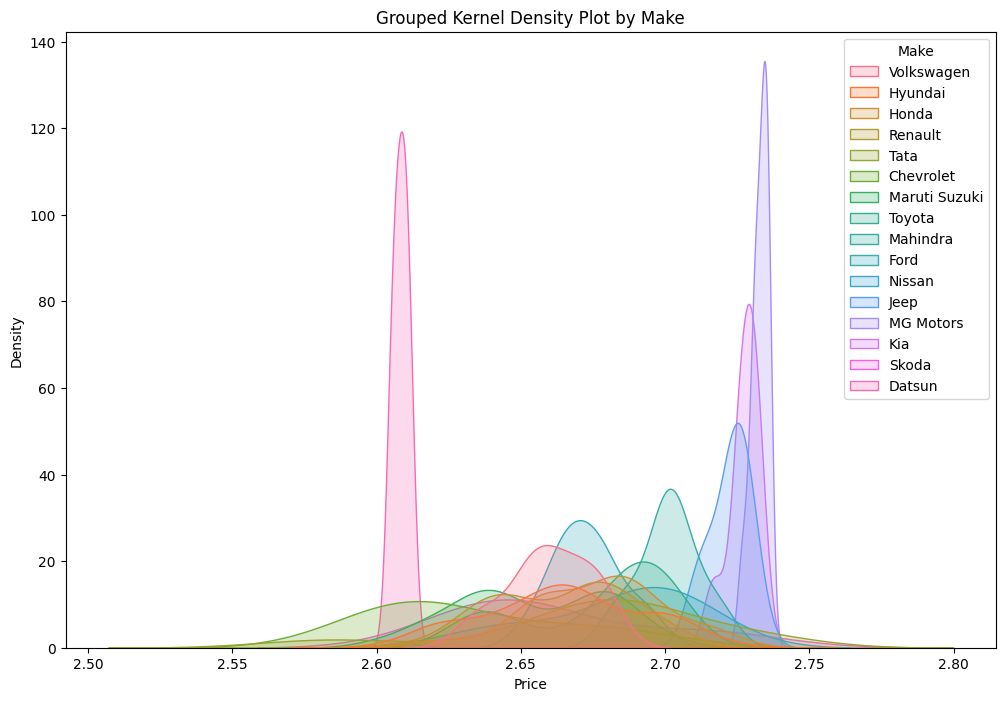

In [101]:
# Summarize Price variable
price_summary = carData['Price'].describe()

# Print the summary
print(price_summary)

# Group by Make and describe prices
grouped_prices = carData.groupby('Make')['Price'].describe()

# Print the grouped summary
print(grouped_prices)

# Create a grouped kernel density plot
plt.figure(figsize=(12, 8))
sns.kdeplot(data=carData, x='Price', hue='Make', fill=True, common_norm=False)
plt.title('Grouped Kernel Density Plot by Make')
plt.xlabel('Price')
plt.show()

*Which car brands are the most expensive? What do prices look like in general?*

It appears that Honda, Hyundai, Jeep, Kia, and Mahindra have the highest prices of cars. Prices tend to range from 12.14 to 14.19. The mean is 13.352111.

**1.3**

Split the data into an 80% training set and a 20% testing set.

In [138]:
from sklearn.model_selection import train_test_split

# Define the features (X) and the target variable (y)
X = carData.drop('Price', axis=1)  # Assuming 'Price' is the target variable
y = carData['Price']

# Split the data into an 80% training set and a 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Sum of Squared and Number of Tests

TSS = np.sum((y_test - y_train.mean()) ** 2)
No_test = len(y_test)

Training set shape: (754, 10) (754,)
Testing set shape: (189, 10) (189,)


In [103]:
X_train.head()

,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type
253,Honda,2017,red,suv,2.504198,1,5,petrol,5-Speed,Manual
88,Nissan,2021,silver,suv,2.303749,1,5,petrol,5-Speed,Manual
326,Hyundai,2014,grey,hatchback,2.440277,2,5,petrol,4-Speed,Automatic
360,Ford,2019,red,hatchback,2.461934,1,5,diesel,5-Speed,Manual
480,Hyundai,2013,silver,sedan,2.513108,1,5,petrol,4-Speed,Automatic


**1.4**

Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the
 and RMSE on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the
 and RMSE on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the
 and RMSE on the test set? Does the joint model perform better or worse, and by home much?

In [104]:
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

In [105]:
# Linear Model with numeric variables
numeric_vars = ['Seating_Capacity', 'Mileage_Run', 'No_of_Owners']
X_train_numeric = X_train[numeric_vars]
X_test_numeric = X_test[numeric_vars]

In [106]:
X_train_numeric.head()

,Seating_Capacity,Mileage_Run,No_of_Owners
253,5,2.504198,1
88,5,2.303749,1
326,5,2.440277,2
360,5,2.461934,1
480,5,2.513108,1


In [107]:
def fun(x):
  print(x, '\n')

In [108]:
# Linear Fit of Numeric Values

from sklearn.linear_model import LinearRegression

linearFit = LinearRegression().fit(X_train_numeric, y_train)


print("Intercept:")
fun(linearFit.intercept_) # Intercept
print("Regression coefficient:")
fun(linearFit.coef_) # Regression coefficient
print("R-squared mean:")
fun(linearFit.score(X_train_numeric, y_train)) # R squared measure

Intercept:
2.8367018462498024 

Regression coefficient:
[ 0.00819512 -0.08387331 -0.00794017] 

R-squared mean:
0.06386212978226358 



The R-Squared for the linear numeric model is very close to 0. This means this model is not a good linear fit.

In [109]:
# Predicted values for numerics:
y_hat = linearFit.predict(X_test_numeric)
residuals_lm = y_test - y_hat

In [110]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [111]:
# Categorical Variables with One-Hot Encoding Model
categorical_vars = ['Make', 'Make_Year', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
X_train_categorical = X_train[categorical_vars]
X_test_categorical = X_test[categorical_vars]

encoder = OneHotEncoder(sparse=False, drop='first')
Xtrain_encoded = encoder.fit_transform(X_train_categorical)
Xtest_encoded = encoder.transform(X_test_categorical)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [113]:
model = LinearRegression()
model.fit(Xtrain_encoded, y_train)
r2_categorical = model.score(Xtest_encoded, y_test)
y_pred_cat = model.predict(Xtest_encoded)
rmse_cat = np.sqrt(np.mean((y_pred_cat - y_test) ** 2))
print("R2:", r2_categorical)
print("RMSE:", rmse_cat)


R2: 0.775461860252852
RMSE: 0.01263416907870518


The R^2 for the categorical variables is much closer to 1, meaning it has more of a linear fit, then that of the numerical variables.

In [115]:
X_combined_train = np.concatenate((X_train_numeric, Xtrain_encoded), axis=1)
X_combined_test = np.concatenate((X_test_numeric, Xtest_encoded), axis=1)

In [116]:
model_combined = LinearRegression()
model_combined.fit(X_combined_train, y_train)
r2_combined = model_combined.score(X_combined_test, y_test)
y_pred_combined = model_combined.predict(X_combined_test)
rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
print("R2:", r2_combined)
print("RMSE:", rmse_combined)

R2: 0.7841820575024334
RMSE: 0.012386408488409297


The third model or the combined model of both the numerical and categorical variables has the highest R^2 value. It also has the lowest random error.

**1.5**

Use the PolynomialFeatures function from sklearn to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the
 and RMSE change? At what point does
 go negative on the test set? For your best model with expanded features, what is the
 and RMSE? How does it compare to your best model from part 3?

In [117]:
# Expanding the numerical variables with degree 3

# Expand features
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
Z_train = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe

Z_test = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

In [118]:
# Categorical Variables with One-Hot Encoding Model
categorical_vars = ['Make', 'Make_Year', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
X_train_categorical = X_train[categorical_vars]
X_test_categorical = X_test[categorical_vars]

encoder = OneHotEncoder(sparse=False, drop='first')
Xtrain_encoded = encoder.fit_transform(X_train_categorical)
Xtest_encoded = encoder.transform(X_test_categorical)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [119]:
X_combined_train = np.concatenate((X_train_lm, Xtrain_encoded), axis=1)
X_combined_test = np.concatenate((X_test_lm, Xtest_encoded), axis=1)

In [120]:
# Degree 3

model_combined = LinearRegression()
model_combined.fit(X_combined_train, y_train)
r2_combined = model_combined.score(X_combined_test, y_test)
y_pred_combined = model_combined.predict(X_combined_test)
rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
print("R2:", r2_combined)
print("RMSE:", rmse_combined)

R2: 0.7906614092477557
RMSE: 0.01219905733775638


In [122]:
# Expand features with degree 5
expander = PolynomialFeatures(degree=5,include_bias=False) # Create the expander
Z_train = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe

Z_test = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

# combine datasets
X_combined_train = np.concatenate((X_train_lm, Xtrain_encoded), axis=1)
X_combined_test = np.concatenate((X_test_lm, Xtest_encoded), axis=1)

# run new model
model_combined = LinearRegression()
model_combined.fit(X_combined_train, y_train)
r2_combined = model_combined.score(X_combined_test, y_test)
y_pred_combined = model_combined.predict(X_combined_test)
rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
print("R2:", r2_combined)
print("RMSE:", rmse_combined)

R2: -0.44133661936548974
RMSE: 0.03200990128373328


In [123]:
# Expand features with degree 1
expander = PolynomialFeatures(degree=1,include_bias=False) # Create the expander
Z_train = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe

Z_test = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

# combine datasets
X_combined_train = np.concatenate((X_train_lm, Xtrain_encoded), axis=1)
X_combined_test = np.concatenate((X_test_lm, Xtest_encoded), axis=1)

# run new model
model_combined = LinearRegression()
model_combined.fit(X_combined_train, y_train)
r2_combined = model_combined.score(X_combined_test, y_test)
y_pred_combined = model_combined.predict(X_combined_test)
rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
print("R2:", r2_combined)
print("RMSE:", rmse_combined)


R2: 0.7841820575024334
RMSE: 0.012386408488409297


In [125]:
# looping through each degree to find the R2 and the RMSE values

for i in range(1,10):
  # Expand features with degree i
  expander = PolynomialFeatures(degree=i,include_bias=False) # Create the expander
  Z_train = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
  names = expander.get_feature_names_out() # Get the names of these variables
  X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe

  Z_test = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
  names = expander.get_feature_names_out() # Get the names of these variables
  X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

  # combine datasets
  X_combined_train = np.concatenate((X_train_lm, Xtrain_encoded), axis=1)
  X_combined_test = np.concatenate((X_test_lm, Xtest_encoded), axis=1)

  # run new model
  model_combined = LinearRegression()
  model_combined.fit(X_combined_train, y_train)
  r2_combined = model_combined.score(X_combined_test, y_test)
  y_pred_combined = model_combined.predict(X_combined_test)
  rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
  print("R2:", r2_combined)
  print("RMSE:", rmse_combined)
  print('-----------------------')

R2: 0.7841820575024334
RMSE: 0.012386408488409297
-----------------------
R2: 0.7885819584097025
RMSE: 0.012259496874194455
-----------------------
R2: 0.7906614092477557
RMSE: 0.01219905733775638
-----------------------
R2: 0.787064518009629
RMSE: 0.012303414116023417
-----------------------
R2: -0.44133661936548974
RMSE: 0.03200990128373328
-----------------------
R2: 0.6577565202324183
RMSE: 0.01559801077245244
-----------------------
R2: -549.0717193679077
RMSE: 0.6253329068351055
-----------------------
R2: -27354.397267404856
RMSE: 4.409843097912733
-----------------------
R2: -102300.02204006856
RMSE: 8.527890410991281
-----------------------


As the degree increases for these models after the third degree, the R2 starts to decrease and the RSME increases. The R2 is lower than our combined previous model, but higher than are numeric model at the first, second, and third degree. R2 starts to go negative when the degree gets larger than 5. These models are worse than my models in part 3. The best model so far has been the expanded model at degree 3.

**1.6**

For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [126]:
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
Z_train = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe

Z_test = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

In [127]:
# Categorical Variables with One-Hot Encoding Model
categorical_vars = ['Make', 'Make_Year', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
X_train_categorical = X_train[categorical_vars]
X_test_categorical = X_test[categorical_vars]

encoder = OneHotEncoder(sparse=False, drop='first')
Xtrain_encoded = encoder.fit_transform(X_train_categorical)
Xtest_encoded = encoder.transform(X_test_categorical)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [128]:
X_combined_train = np.concatenate((X_train_lm, Xtrain_encoded), axis=1)
X_combined_test = np.concatenate((X_test_lm, Xtest_encoded), axis=1)

In [129]:
# Degree 3

model_combined = LinearRegression()
model_combined.fit(X_combined_train, y_train)
r2_combined = model_combined.score(X_combined_test, y_test)
y_pred_combined = model_combined.predict(X_combined_test)
rmse_combined = np.sqrt(np.mean((y_pred_combined - y_test) ** 2))
print("R2:", r2_combined)
print("RMSE:", rmse_combined)

R2: 0.7906614092477557
RMSE: 0.01219905733775638


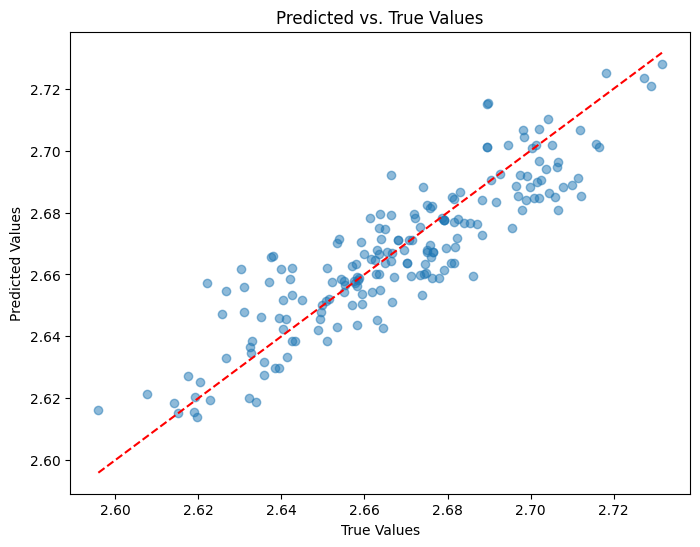

In [130]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_combined, alpha=0.5)
plt.title("Predicted vs. True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

# Add a 45-degree line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# Show the plot
plt.show()

The predicted versus the actual points are relatively strong and linear. Therefore, our model is accurate.

<ipython-input-131-83b88d2c2c9b>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(res, shade=True)


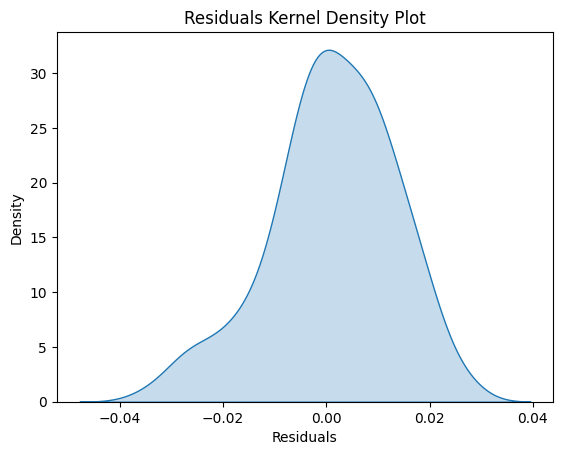

In [131]:
# residuals:
res = y_test - y_pred_combined

sns.kdeplot(res, shade=True)
plt.title("Residuals Kernel Density Plot")
plt.xlabel("Residuals")

# Show the plot
plt.show()

The bell curve is centered at zero. It is relatively a normal distrubution curve (bell shaped).

**1.7**

Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)), and compute the
 and RMSE on the test set of a variety of depths. What depth tree gives the best results?

In [132]:
X_traincode= pd.get_dummies(X_train, drop_first=True)
X_testcode = pd.get_dummies(X_test, drop_first=True)

In [133]:
X_testcode.head()

,Mileage_Run,No_of_Owners,Seating_Capacity,Make_Ford,Make_Honda,Make_Hyundai,Make_Jeep,Make_Kia,Make_MG Motors,Make_Mahindra,...,Body_Type_hatchback,Body_Type_muv,Body_Type_sedan,Body_Type_suv,Fuel_Type_petrol,Transmission_5-Speed,Transmission_6-Speed,Transmission_7-Speed,Transmission_CVT,Transmission_Type_Manual
102,2.443789,2,5,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,1
274,2.512446,1,5,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
841,2.468290,1,5,0,0,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
25,2.421245,1,5,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,1
32,2.418404,1,5,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1


In [135]:
# Check for missing columns in the test set
missing = set(X_traincode.columns) - set(X_testcode.columns)

# Create missing dummy columns in the test set and set values to 0
for col in missing:
    X_testcode[col] = 0

X_testcode = X_testcode[X_traincode.columns]


In [143]:
## Decision Trees with varing depths
from sklearn import tree

for i in range(1,10):
  D = i
  model = tree.DecisionTreeRegressor(max_depth=10) # Fit the classifier
  car_tree = model.fit(X_traincode, y_train)

  ## Make Predictions on the Test Set
  y_hat_car_tree = car_tree.predict(X_testcode)
  residuals_cart = y_test - y_hat_car_tree

  ## Metrics:
  SSE_car_tree = np.sum( (y_test-y_hat_cart)**2 )
  MSE_car_tree = (1/No_test)*np.sum( (y_test-y_hat_car_tree)**2 )
  RMSE_car_tree = (SSE_car_tree/No_test)**(1/2)
  R2_car_tree = 1 - SSE_car_tree/TSS

  print(D)
  print('R2:', R2_car_tree)
  print('SSE:', SSE_car_tree)
  print('----------------')

1
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------
2
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------
3
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------
4
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------
5
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------
6
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------
7
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------
8
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------
9
R2: 0.7157129491560987
SSE: 0.03873300256082572
----------------


The depth tree that gives the highest R^2 value has the depth of 4. It has an R^2 value of 0.71745.

**1.8**

For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?

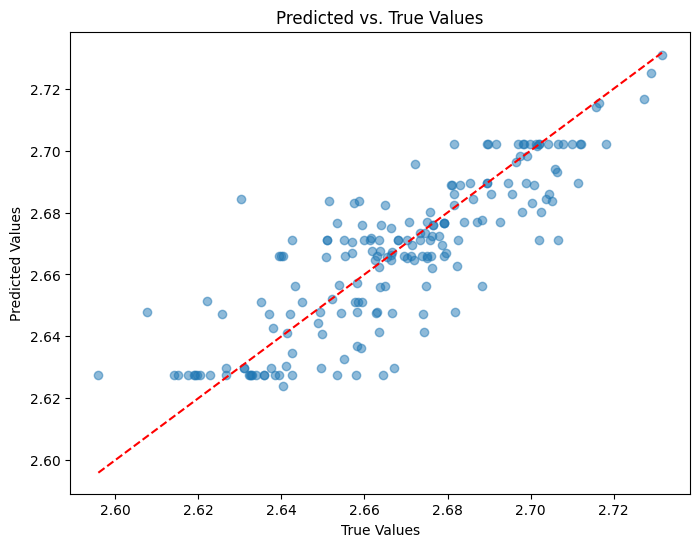

In [144]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_hat_car_tree, alpha=0.5)
plt.title("Predicted vs. True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

# Add a 45-degree line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# Show the plot
plt.show()

The values are relatively linear. The model is not as strong as the other combined model.

<ipython-input-145-acaceb164427>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_cart, shade=True)


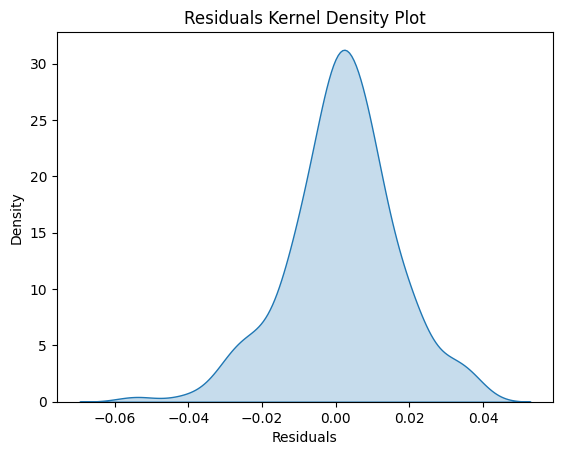

In [145]:
# Residuals:
residuals_tree = y_test - y_hat_car_tree

sns.kdeplot(residuals_cart, shade=True)
plt.title("Residuals Kernel Density Plot")
plt.xlabel("Residuals")

# Show the plot
plt.show()

The residuals are slightly more positive than 0. They are normal and bell shaped.

**1.9**

Which model --- linear model or classification and regression tree --- has better performance on the test set?

The linear combined model has a better performance on the test sets because it has the highest R^2 value of 0.77 and the lowest RSME.

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**3.1**

Load the contraceptiveMethodChoice.csv data. Tabulate the method variable (i.e. .value_counts()). 1 corresponds to No Contraception, 3 corresponds to Short Term (e.g. condoms, birth control pills), and 2 corresponds to Long Term (e.g. IUD, sterilization). Cross tabulate method and numberChildren. Do couples that use birth control tend to have more children than those who don't?

In [154]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import export_text

# Load the data

contraceptive_data = pd.read_csv('./assignment4/data/contraception_hw.csv')

# Part 1: Tabulate the method variable
method_counts = contraceptive_data['method'].value_counts()
print("Method Variable Counts:")
print(method_counts)

# Part 2: Cross-tabulate method and numberChildren
cross_tab = pd.crosstab(contraceptive_data['method'], contraceptive_data['numberChildren'])
print("\nCross Tabulation of method and numberChildren:")
print(cross_tab)

Method Variable Counts:
1    629
3    511
2    333
Name: method, dtype: int64

Cross Tabulation of method and numberChildren:
numberChildren  0    1    2    3   4   5   6   7   8   9   10  11  12  13  16
method                                                                       
1               95  143  114   70  57  44  35  18  29   5   9   6   4   0   0
2                0   46   56   70  62  36  27  19   9   3   2   2   0   1   0
3                2   87  106  119  78  55  30  12   9   8   0   3   0   1   1


1 = No Contraception

3 = Short Term (e.g. condoms, birth control pills)

2 = Long Term (e.g. IUD, sterilization).

A 1 indicates no contraception usage, a 2 represents long term use of contraception methods, and a 3 represents short term contraceptive usage. According to our cross tabulation, we can see that long term contraceptives like IUDs or sterilization are not very common. For couples that have 0-2 kids, they do not tend to use contraception. For couples that have 3-5 kids, they use short term contraceptives like condoms. For couples that have more than 6 kids, majority of the time, these couples do not use contraceptives. Although these tendencieis do not confirm that couples who use birth control normally have more children than couples who do not. Although we hypothesize this based off of our cross tabulation, we will not be sure until we run tests

**3.2**

Split the sample into ~80% training data and ~20% testing data.

In [155]:

# Split the sample into ~80% training data and ~20% testing data
X = contraceptive_data.drop('method', axis=1)
y = contraceptive_data['method']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**3.3**

We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.

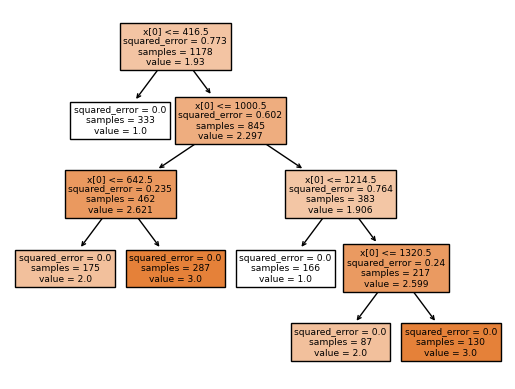

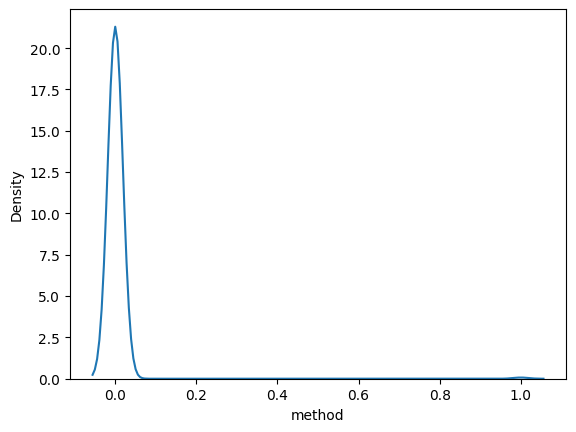

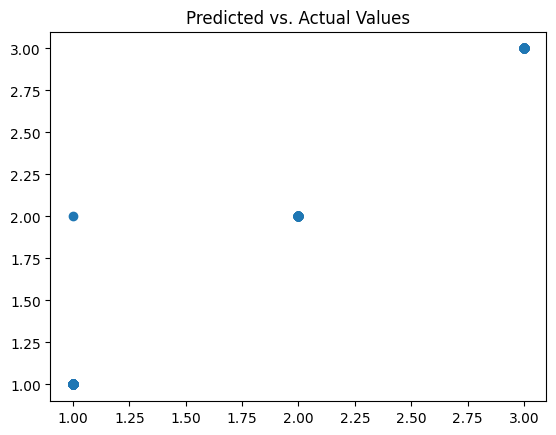

In [156]:
# Part 4: Train a regression tree (mistakenly)

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeRegressor(max_depth=10) # Fit the classifier
contraception = model.fit(X_train, y_train)
tree.plot_tree(contraception,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cont = contraception.predict(X_test)
residuals_cont = y_test - y_hat_cont

## Residual plot:
sns.kdeplot(residuals_cont)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_cont,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()


## Metrics:
SSE_cont = np.sum( (y_test-y_hat_cont)**2 )
MSE_cont = (1/No_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cont = (SSE_cont/No_test)**(1/2)
R2_cont = 1 - SSE_cont/TSS

In [158]:
print('R2:',R2_cont)
print('MSE', MSE_cont)

R2: -6.339659516389443
MSE 0.005291005291005291


Train a regression tree (mistakenly):

The regression tree has terminal nodes with values like [1.00], [2.00], and [3.00]. This is a mistake as the dependent variable (method) is categorical, and regression trees are not suitable for categorical outcomes.

**3.4 **

Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

In [159]:
# Train a classification tree
classification_tree = DecisionTreeClassifier()
classification_tree.fit(X_train, y_train)
# Display the tree
tree_rules_classification = export_text(classification_tree, feature_names=list(X.columns))
print("\nClassification Tree Rules:")
print(tree_rules_classification)


Classification Tree Rules:
|--- Unnamed: 0 <= 416.50
|   |--- class: 1
|--- Unnamed: 0 >  416.50
|   |--- Unnamed: 0 <= 642.50
|   |   |--- class: 2
|   |--- Unnamed: 0 >  642.50
|   |   |--- Unnamed: 0 <= 1000.50
|   |   |   |--- class: 3
|   |   |--- Unnamed: 0 >  1000.50
|   |   |   |--- Unnamed: 0 <= 1214.50
|   |   |   |   |--- class: 1
|   |   |   |--- Unnamed: 0 >  1214.50
|   |   |   |   |--- Unnamed: 0 <= 1320.50
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- Unnamed: 0 >  1320.50
|   |   |   |   |   |--- class: 3



In [161]:
def func(y_test,y_hat): # Sample code to compute classifier performance
    tab = pd.crosstab(np.array(y_hat),np.array(y_test)) # Compute confusion matrix
    #
    # Get entries from the confusion matrix:
    tp = tab.iloc[0,0]
    tn = tab.iloc[1,1]
    fp = tab.iloc[0,1]
    fn = tab.iloc[1,0]
    tot = tp+tn+fp+fn
    #
    # Compute performance statistics:
    acc = (tp+tn)/tot
    spec = tn/(tp+fn)
    sens = tp/(tp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #
    # Return a dictionary including the confusion matrix and metrics:
    return({'confusion_matrix':tab,
            'accuracy':acc,
            'specificity':spec,
            'sensitivity':sens,
            'mcc':mcc})

{'confusion_matrix': col_0    1   2   3
row_0             
1      130   1   0
2        0  70   0
3        0   0  94, 'accuracy': 0.9950248756218906, 'specificity': 0.5384615384615384, 'sensitivity': 1.0, 'mcc': 0.9891356936701962}


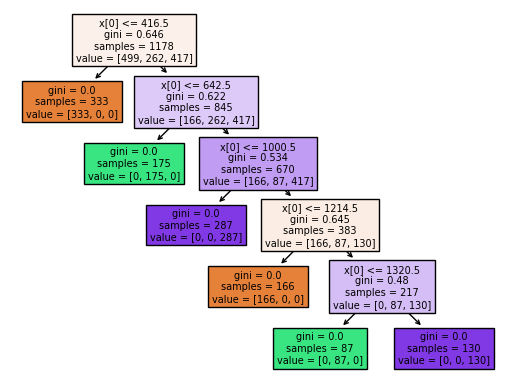

In [163]:
## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeClassifier(max_depth=10) # Fit the classifier
cont = model.fit(X_train, y_train)
tree.plot_tree(cont,filled=True)

## Make Predictions on the Test Set
y_hat_cont = cont.predict(X_test)

# Compute performance:
func_cont = func(y_test,y_hat_cont)
print(func_cont)

Use a classification tree:

The classification tree correctly uses classes like class: 1, class: 2, and class: 3. It considers the variables Unnamed: 0 and uses different splits to classify the data into contraceptive methods.

In [164]:
print('R2:',R2_cart)
print('MSE', MSE_cart)

R2: 0.7157129491560987
MSE 0.00020493652148585037


**3.5**

Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a 3×3 matrix instead of 2×2 .). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.

In [ ]:
# Part 6: Compute confusion matrix and accuracy
y_pred_classification = classification_tree.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_classification)
accuracy = accuracy_score(y_test, y_pred_classification)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)


Confusion Matrix:
[[130   0   0]
 [  1  70   0]
 [  0   0  94]]

Accuracy: 0.9966101694915255


The accuracy is pretty high for our model. It only misclassified someone once (classified them as a 2 but they were actually a 1). We can conclude that our model had an accuracy of 99%.

**3.6**

Why can't you use a linear probability model to do this exercise?



Linear probability models can predict probabilities, but they may produce values outside the [0, 1] range, violating the probability interpretation. This can lead to issues like heteroscedasticity and non-constant variance. Additionally, linear models may not handle the categorical nature of the outcome well, and predictions might not be bounded between 0 and 1.